# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.


The data was organized  by Dr. Sina Kashuk at CUSP.
You can get it from the github repo (use the download link to download it live in your notebook). 
It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [62]:
import urllib
import pandas as pd
import numpy as np
import requests
import urllib.request
import os
import pylab as pl
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

## Each time series (per station, per ticket type) contains the number of swipes per week for 194 weeks from 05/21/2010 to 02/21/2014. 

The data are available to you as a *python data cube*. you can load it as 

```
np.load(“MTA_Fare.npy")
```

and you will end up with a python numpy array of 
shape (600, 23, 194)




In [3]:
mta = np.load("MTA_Fare.npy")

In [4]:
mta.shape

(600, 23, 194)

## Task 1: 
### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
### Identify it, figure out the date (you know when the data starts and what the cadence is) and figure out what it is due to.


In [5]:

mta = mta.astype(float)
mta[mta==-1] = np.nan


In [6]:
#as described in the instruction for some of the analysis 
#one can sum time series for all stations
print (mta.shape)
mta_stasum = np.nansum(mta, axis=0)
print (mta_stasum.shape)
#or for all ride types
mta_typesum = np.nansum(mta, axis=1)
print (mta_typesum.shape)
#leave swipe only
mta_allsum = np.nansum(mta_typesum,axis =0)
print (mta_allsum.shape)



(600, 23, 194)
(23, 194)
(600, 194)
(194,)


In [7]:
#wipe 2 weeks at the tail to fit 194
date = pd.date_range(start="05-21-2010",end="02-7-2014",freq="W")

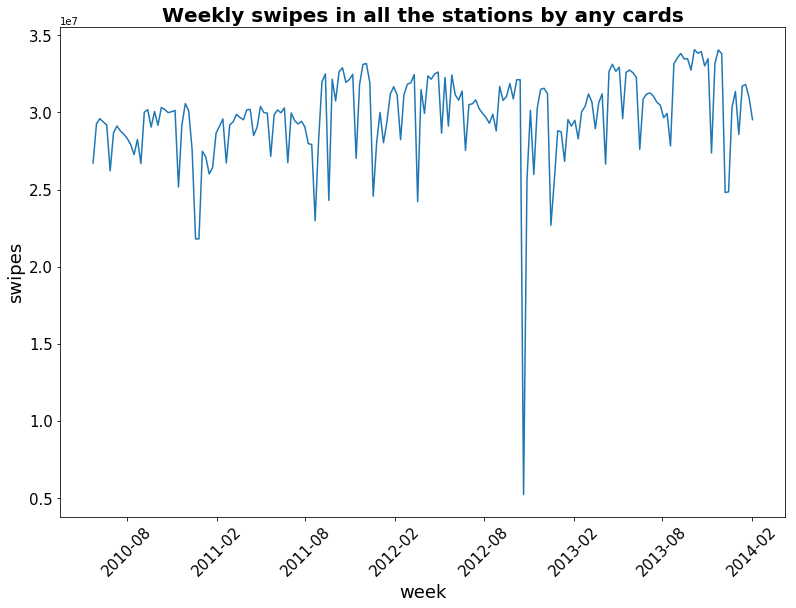

In [8]:
pl.figure(figsize=(13,9))
pl.plot(date, mta_allsum)
pl.xlabel("week", fontsize=18)
pl.ylabel("swipes", fontsize=18)
pl.xticks(rotation=45, fontsize=15)
pl.yticks(fontsize=15)
pl.title('Weekly swipes in all the stations by any cards', fontsize = 20, weight='bold')
pl.show()

Figure 1 : Swipes weekly in NYC from 05-21-2010 to 02-21-2014 (all stations any cards).

Figure shows that an prominent outlier appears around 10-2012.

In [9]:
np.argmin(mta_allsum)

126

In [10]:
prominent = datetime(2010,5,21) + 126*timedelta(7)
prominent

datetime.datetime(2012, 10, 19, 0, 0)

### I think the significant drop of swipes at that week is due to Sandy Hurricane.

## Task 2: 
### Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


In [11]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
ridetype

array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp', 'ez',
       'ff', 'mc', 'mr', 'month', 'rfm', 'rr', 'sen', 'spec', 'tcmc', 't',
       'umlim', 'xbus', 'stud'], 
      dtype='<U5')

In [12]:
mta_stasum_T = mta_stasum.T
mta_stasum_T

array([[  1.14946150e+07,   5.30524000e+05,   4.78010000e+04, ...,
          6.12800000e+03,   3.58000000e+02,   0.00000000e+00],
       [  1.25268590e+07,   5.83533000e+05,   5.14860000e+04, ...,
          6.12000000e+03,   4.74000000e+02,   0.00000000e+00],
       [  1.27666270e+07,   5.86194000e+05,   5.16360000e+04, ...,
          6.49000000e+03,   4.65000000e+02,   0.00000000e+00],
       ..., 
       [  1.31896100e+07,   6.95134000e+05,   5.87710000e+04, ...,
          5.39800000e+03,   8.62000000e+02,   1.13272300e+06],
       [  1.25007560e+07,   6.70228000e+05,   5.65250000e+04, ...,
          5.75900000e+03,   8.10000000e+02,   1.37940300e+06],
       [  1.24599470e+07,   6.79497000e+05,   5.51920000e+04, ...,
          6.18400000e+03,   8.20000000e+02,   5.35018000e+05]])

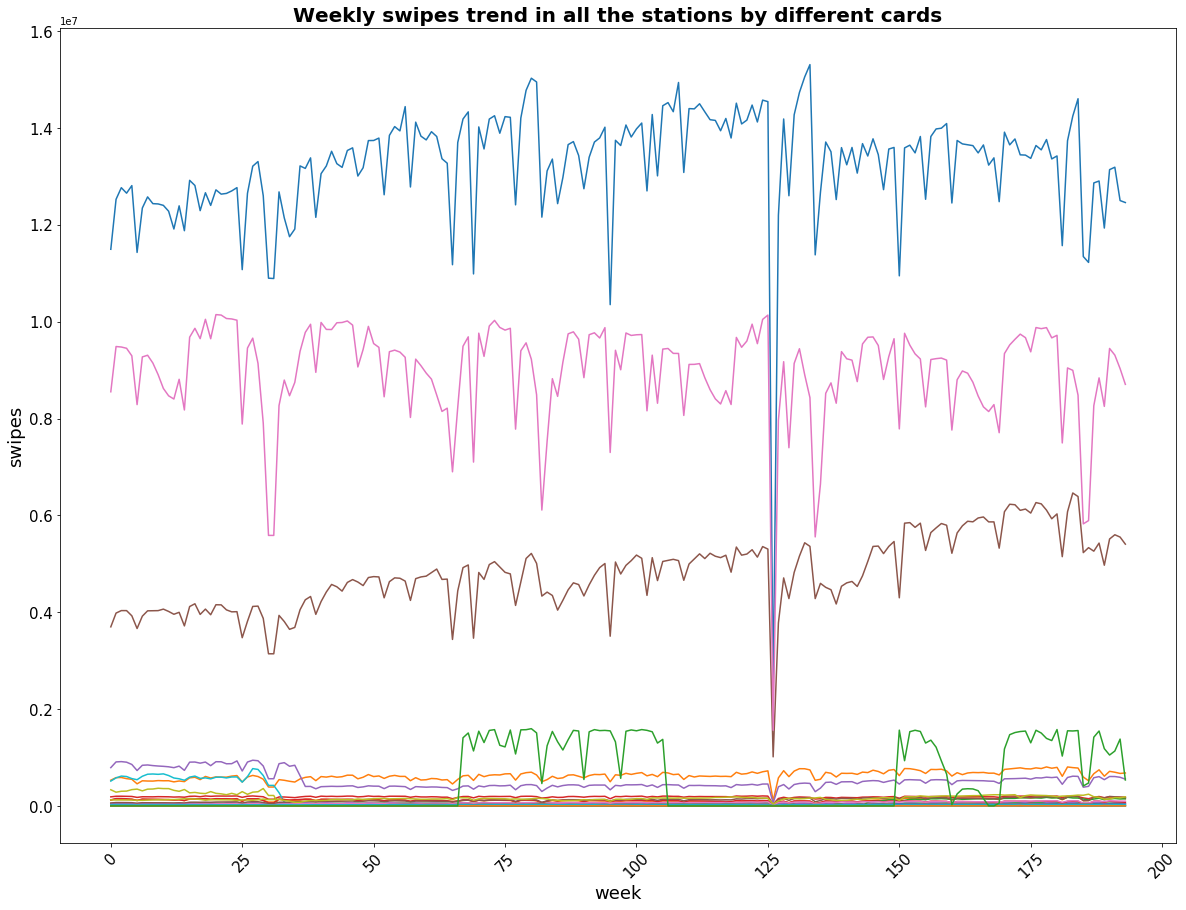

In [13]:
pl.figure(figsize=(20,15))
pl.plot(mta_stasum_T)
pl.xlabel("week", fontsize=18)
pl.ylabel("swipes", fontsize=18)
pl.xticks(rotation=45, fontsize=15)
pl.yticks(fontsize=15)
pl.title('Weekly swipes trend in all the stations by different cards', fontsize = 20, weight='bold')
pl.show()

Figure 2 : Trends of swipes by different card types in all stations(sum). Each color represents a kind of card type. Obviously, it is hard to find some trend in this plot. We have to do some smooth and draw them seperately.

In [14]:
card_smooth = pd.rolling_mean(mta_stasum_T,10)

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  if __name__ == '__main__':


In [15]:
df = pd.DataFrame(card_smooth)

In [16]:
df.columns = ridetype

In [17]:
df.head()

10t  14d  1d  2t  30d  7d  ada  afas  exp  ez  ...   month  rfm  rr  sen  \
0  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...     NaN  NaN NaN  NaN   
1  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...     NaN  NaN NaN  NaN   
2  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...     NaN  NaN NaN  NaN   
3  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...     NaN  NaN NaN  NaN   
4  NaN  NaN NaN NaN  NaN NaN  NaN   NaN  NaN NaN  ...     NaN  NaN NaN  NaN   

   spec  tcmc   t  umlim  xbus  stud  
0   NaN   NaN NaN    NaN   NaN   NaN  
1   NaN   NaN NaN    NaN   NaN   NaN  
2   NaN   NaN NaN    NaN   NaN   NaN  
3   NaN   NaN NaN    NaN   NaN   NaN  
4   NaN   NaN NaN    NaN   NaN   NaN  

[5 rows x 23 columns]

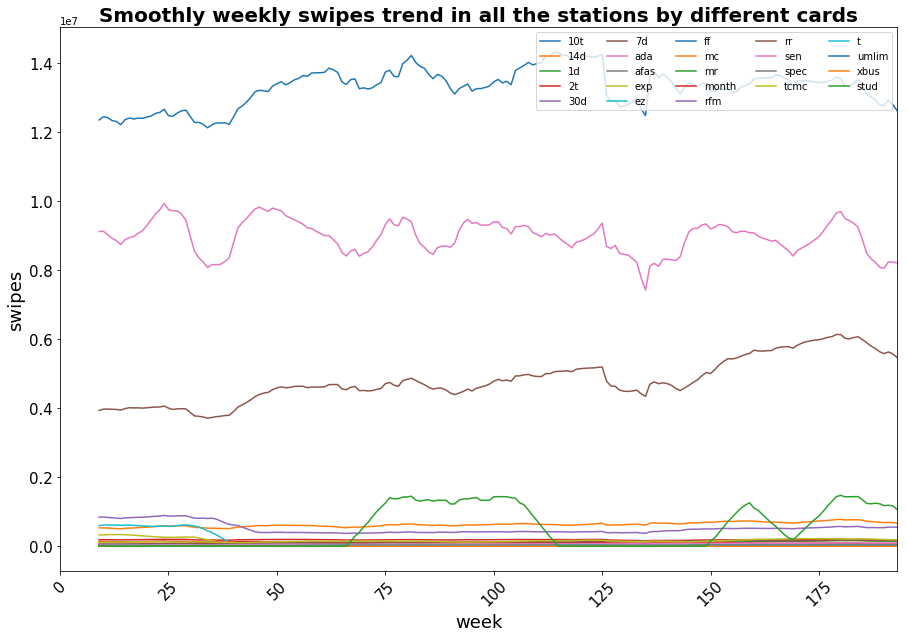

In [18]:

df.plot(figsize=(15,10))
pl.xlabel("week", fontsize=18)
pl.ylabel("swipes", fontsize=18)
pl.xticks(rotation=45, fontsize=15)
pl.yticks(fontsize=15)
pl.legend(loc = 1,ncol = 5)
pl.title('Smoothly weekly swipes trend in all the stations by different cards', fontsize = 20, weight='bold')
pl.show()

Figure 3 : Smoothly by np.rolling_mean, window =5.

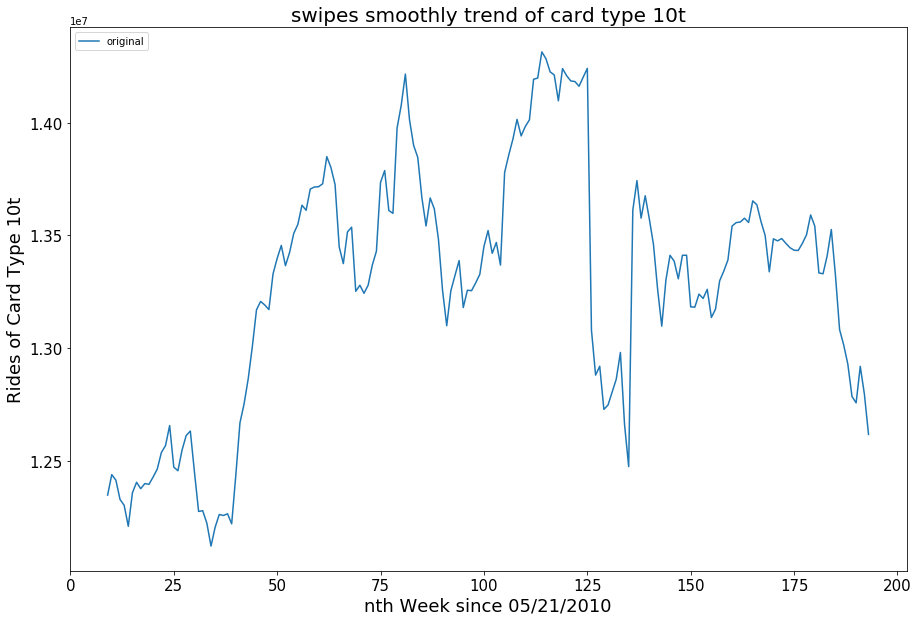

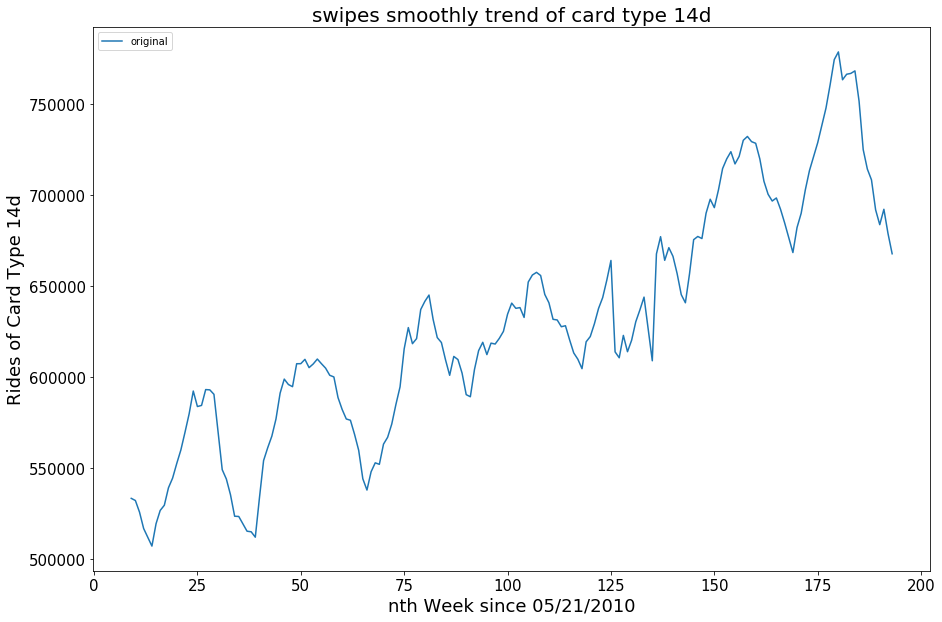

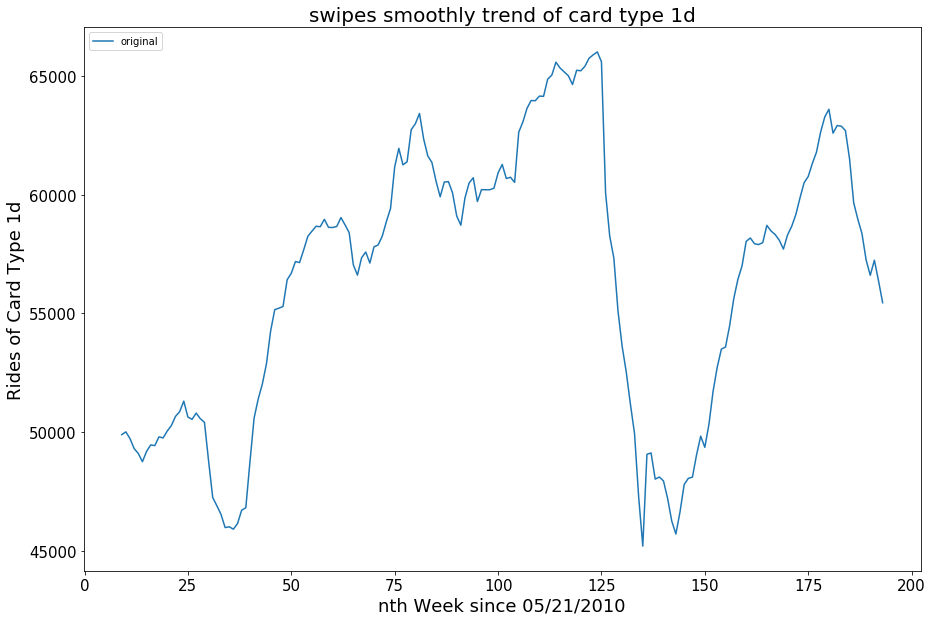

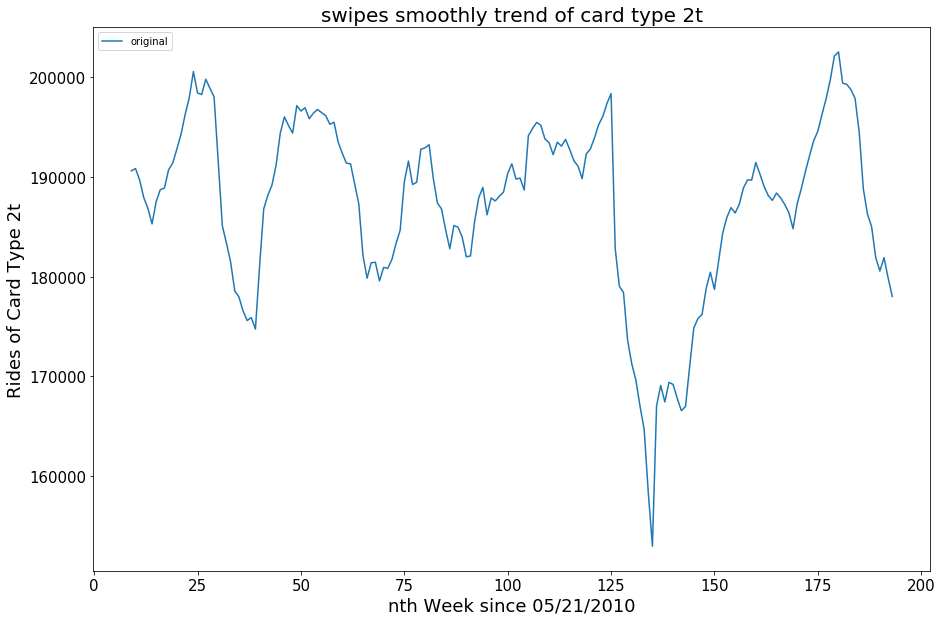

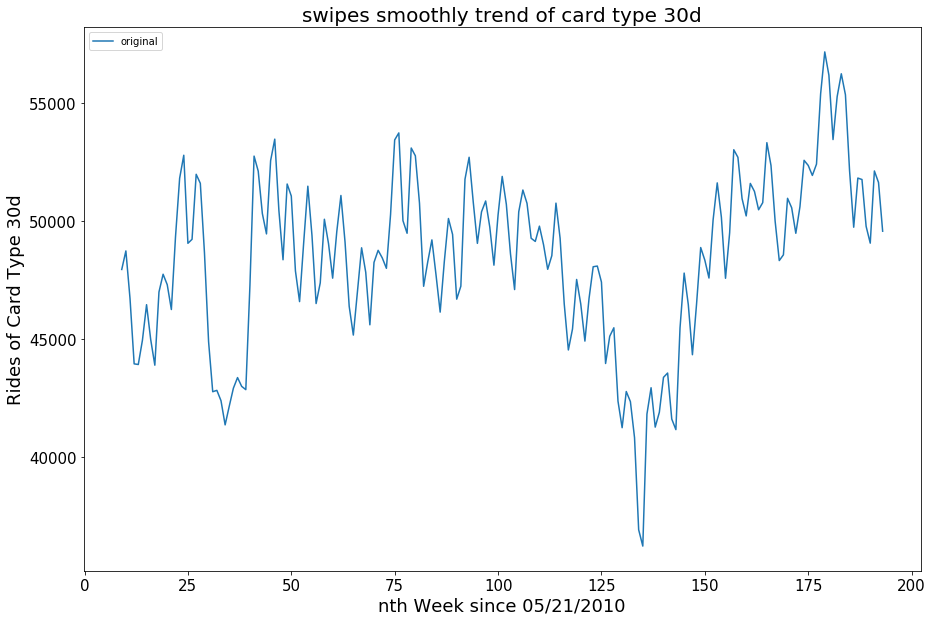

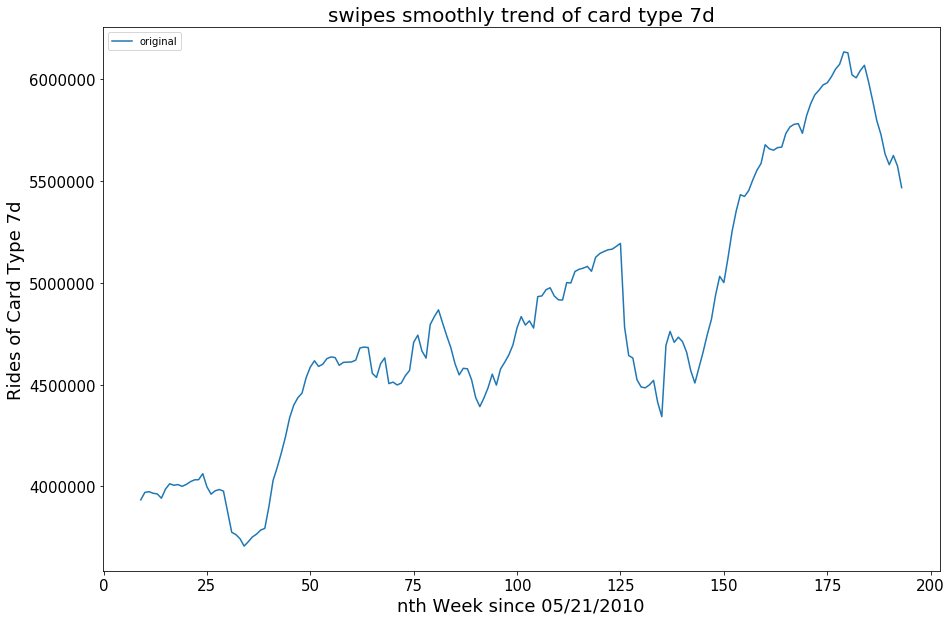

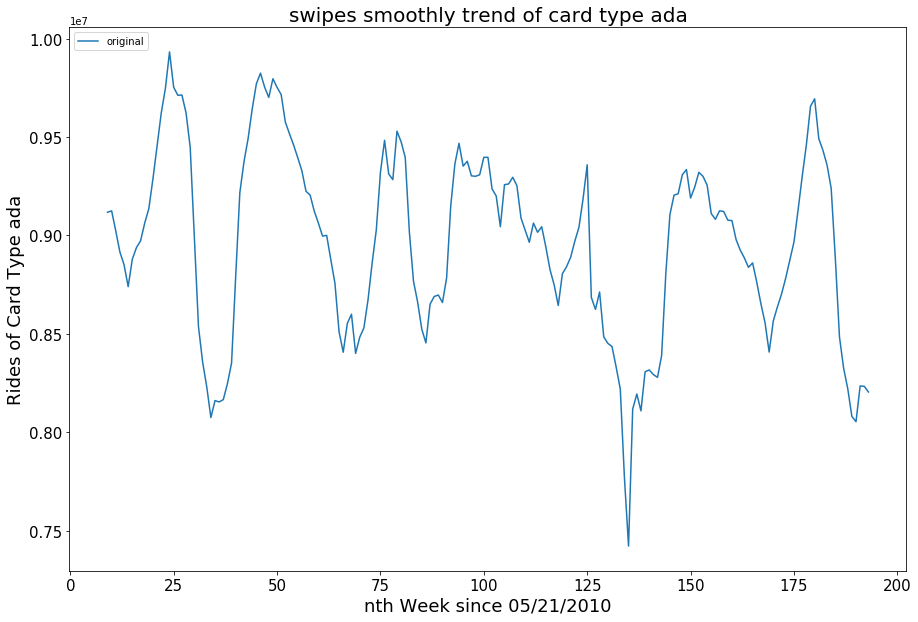

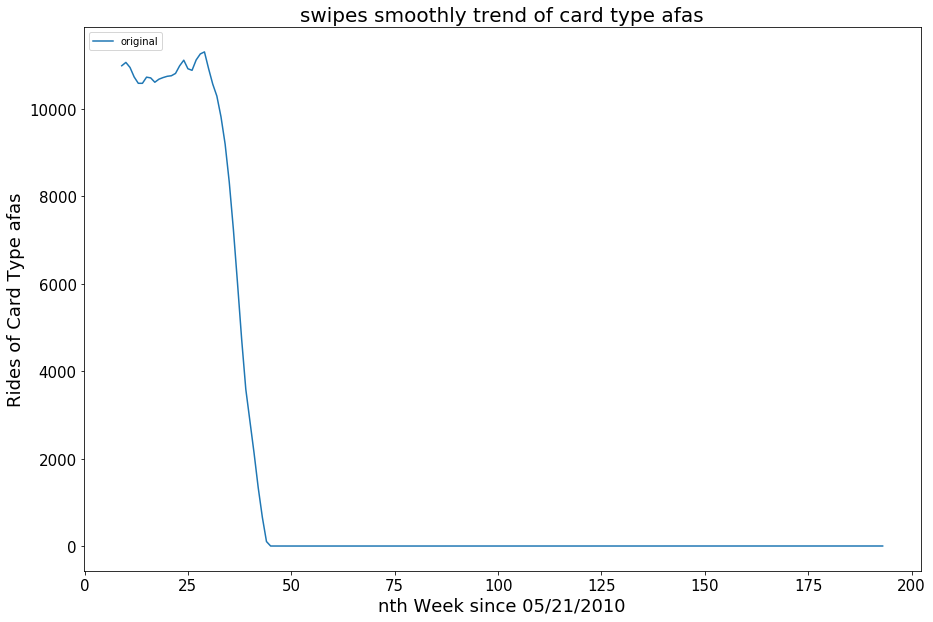

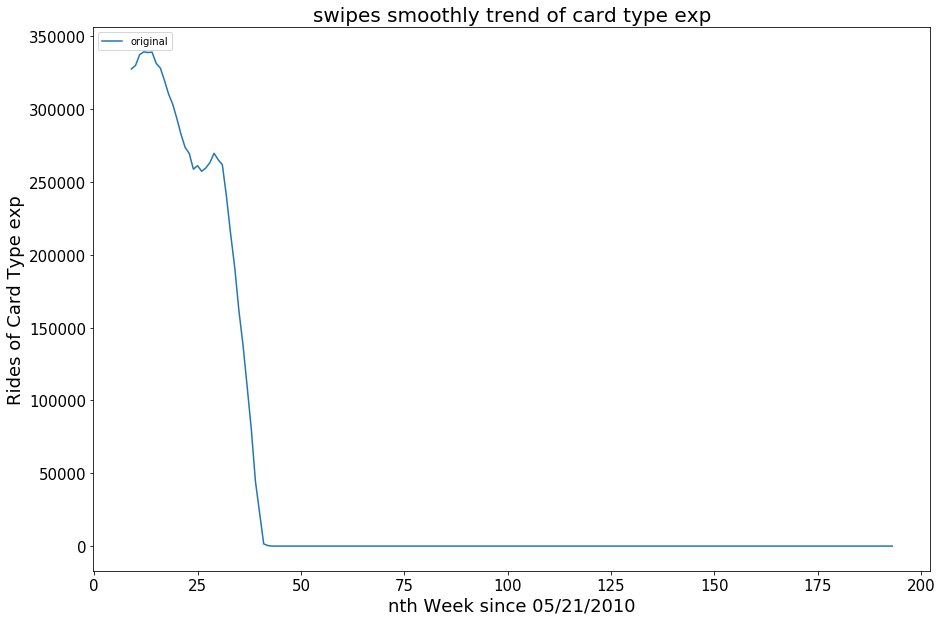

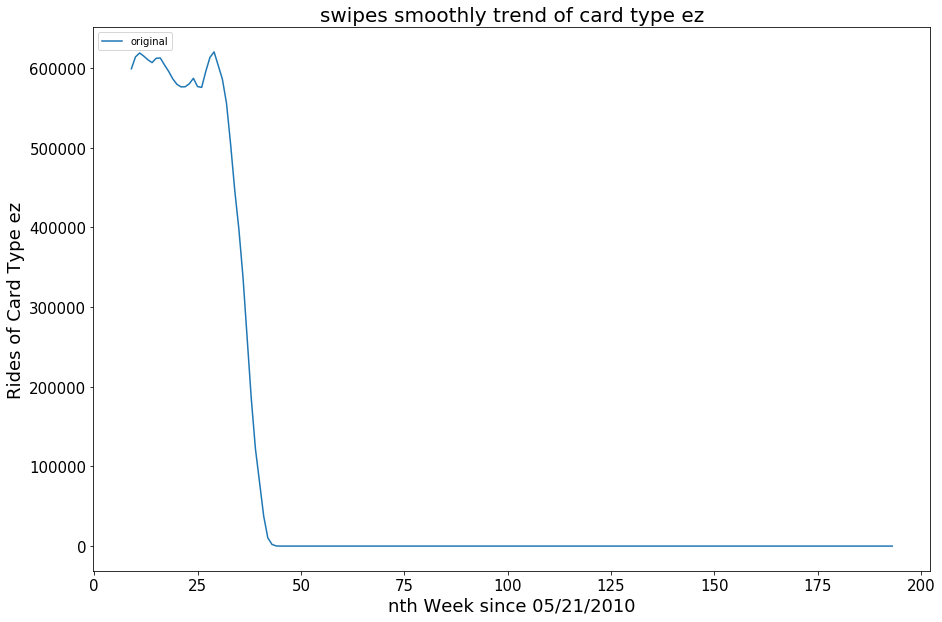

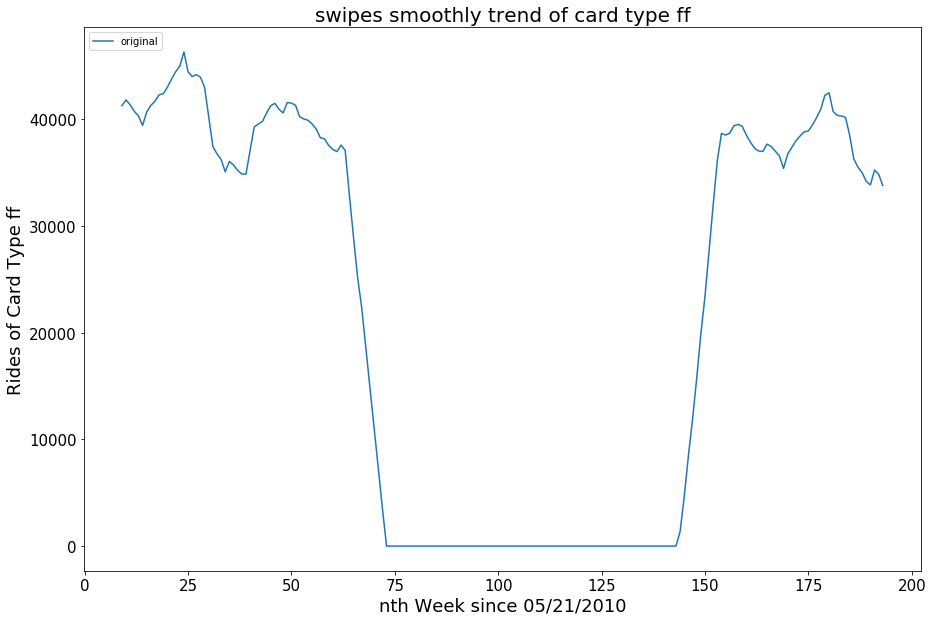

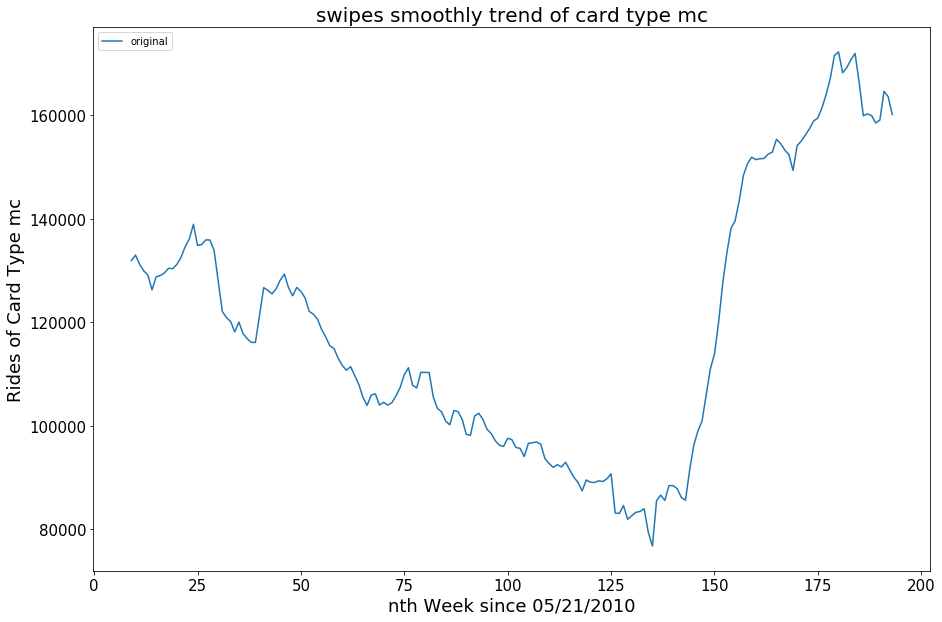

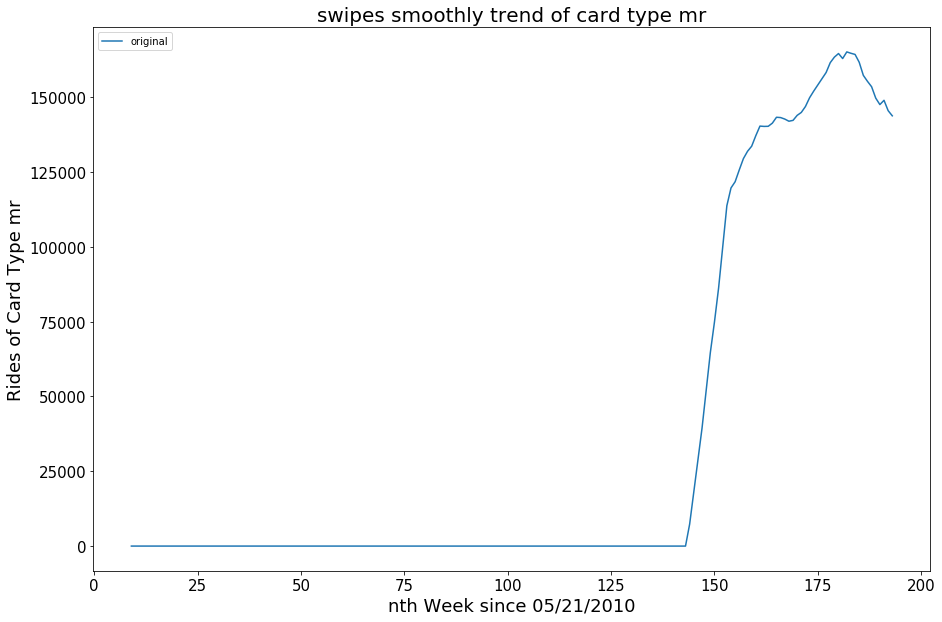

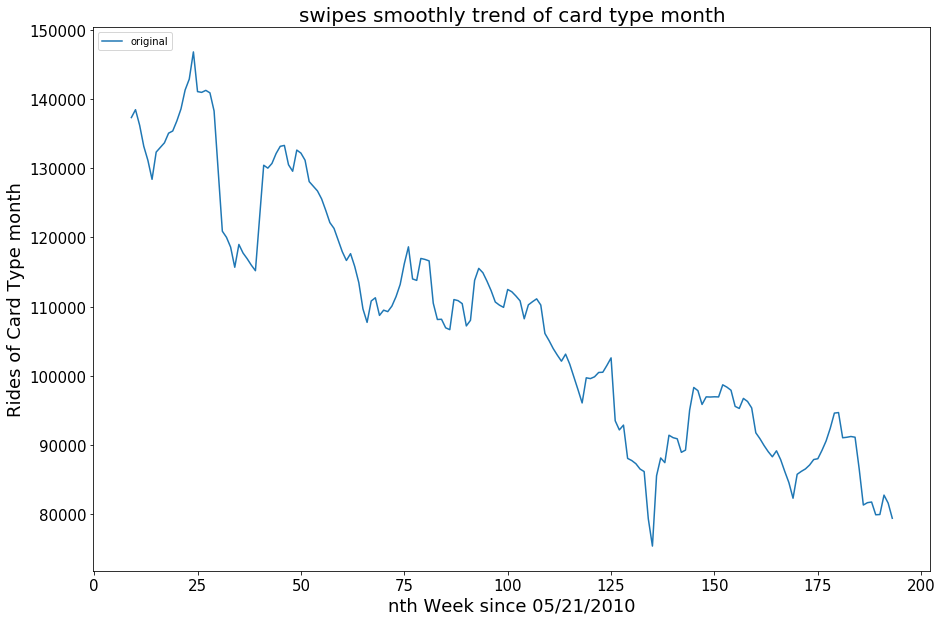

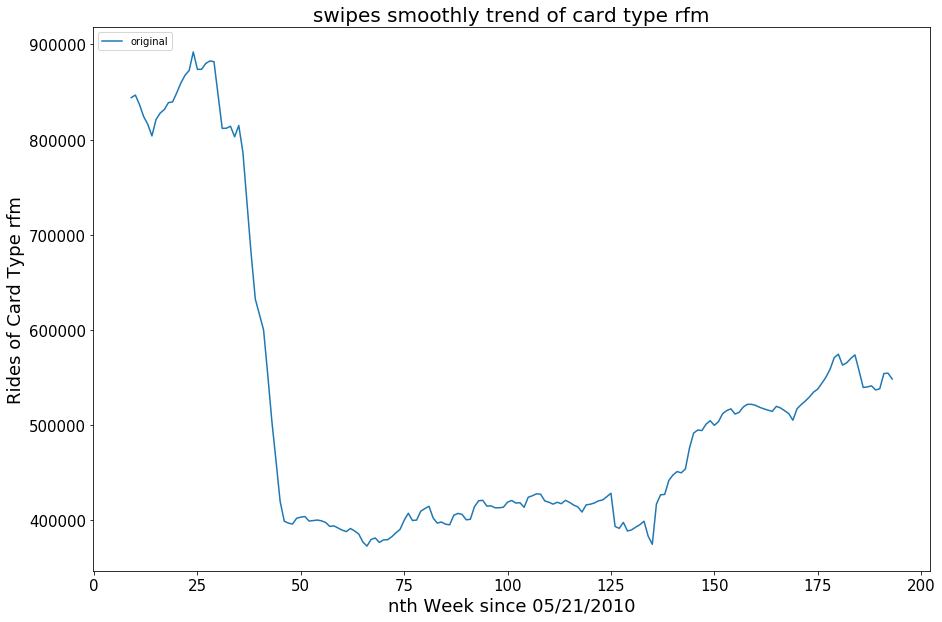

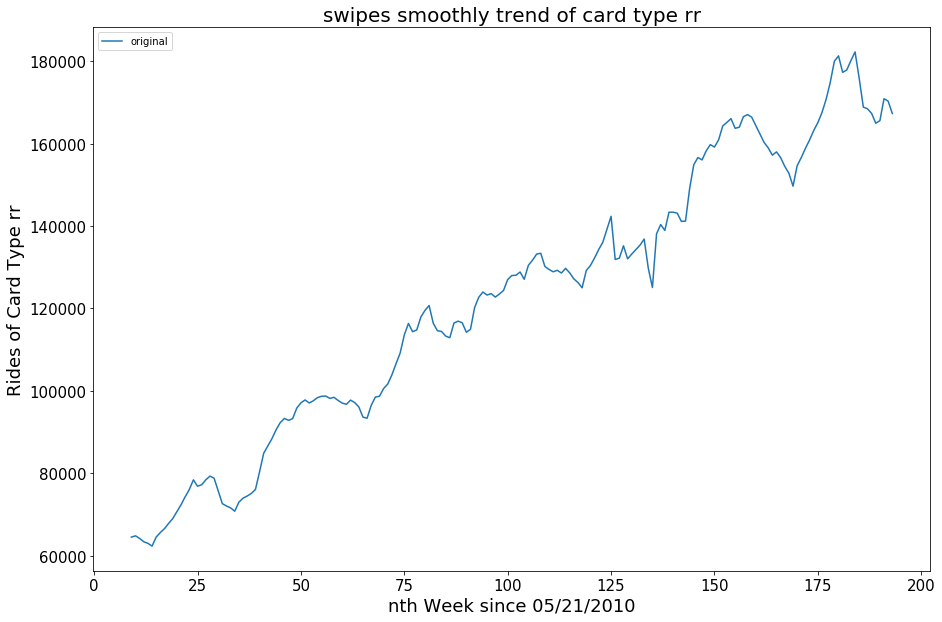

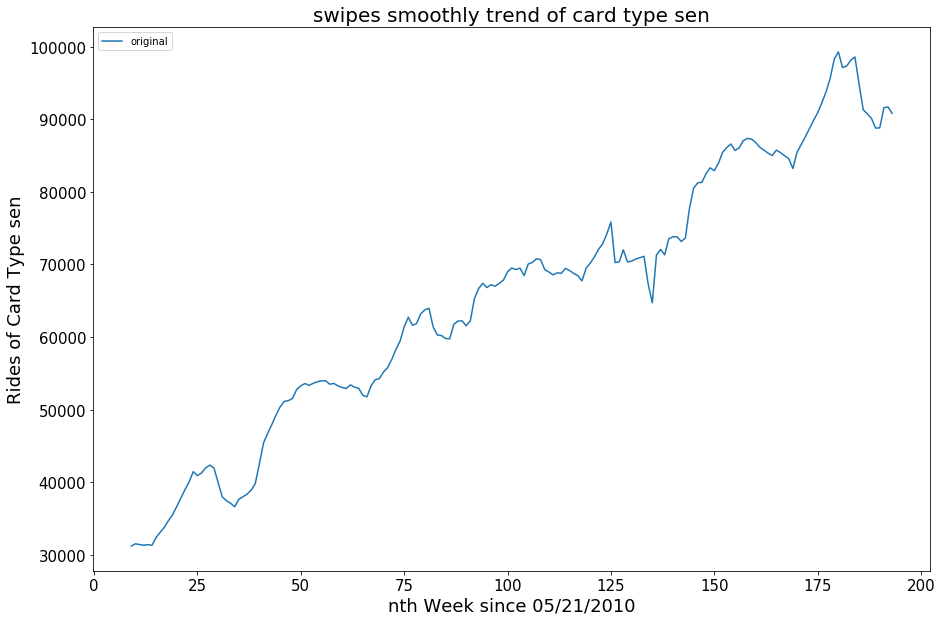

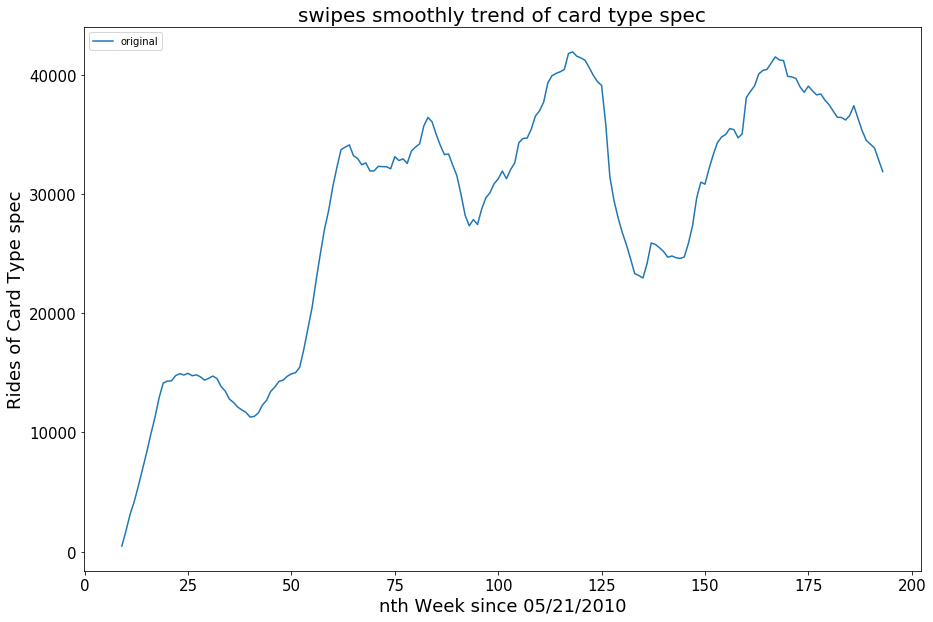

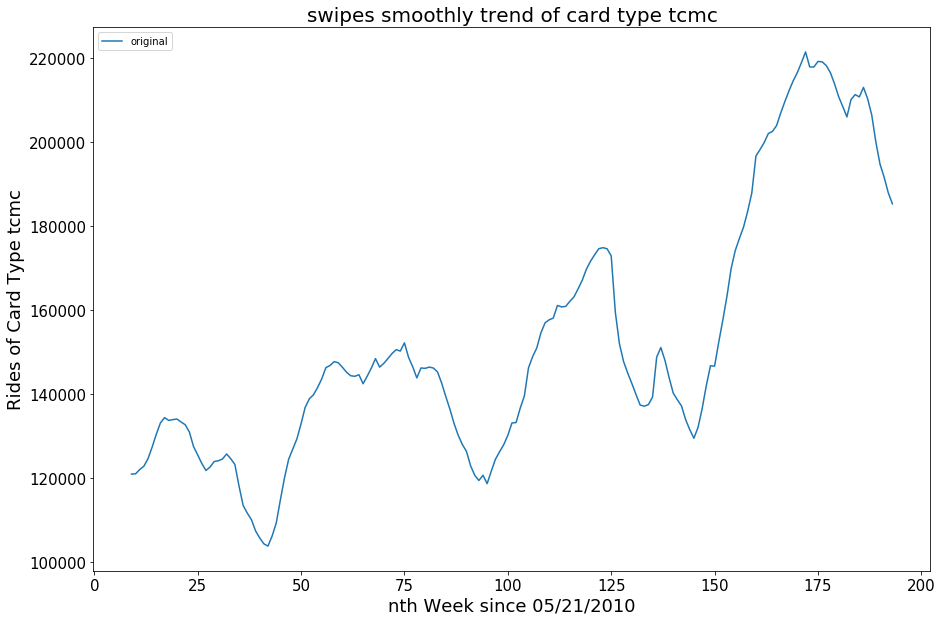

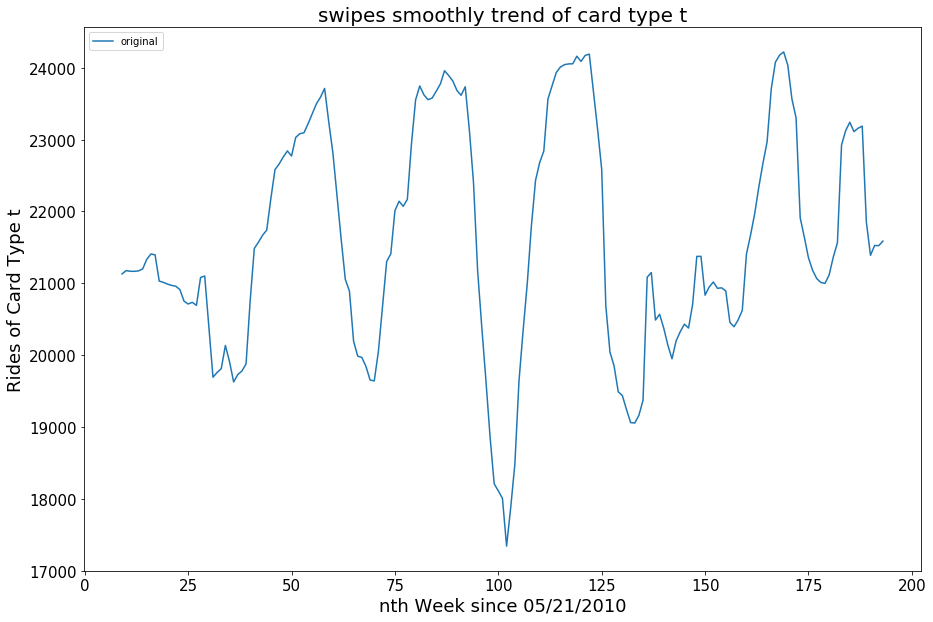

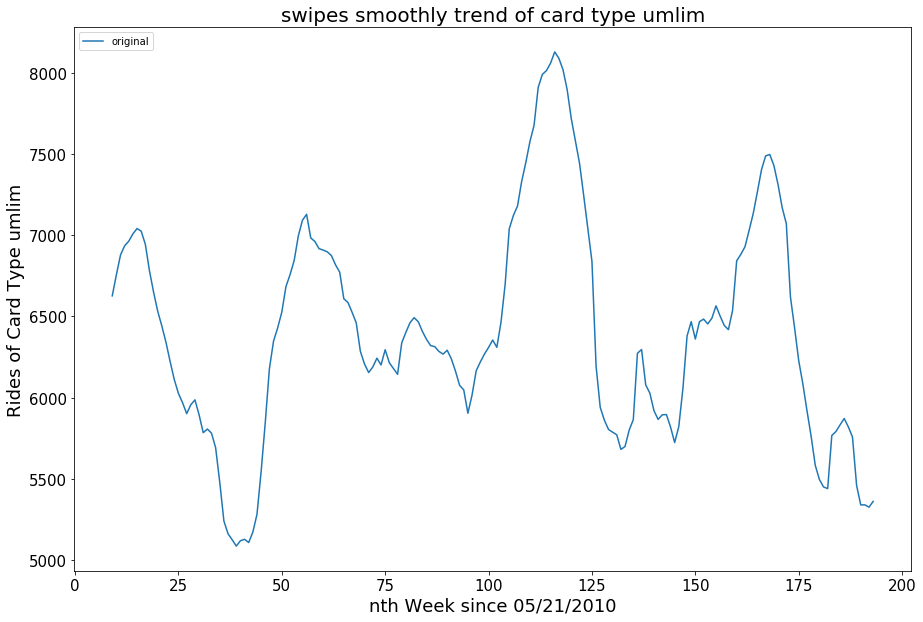

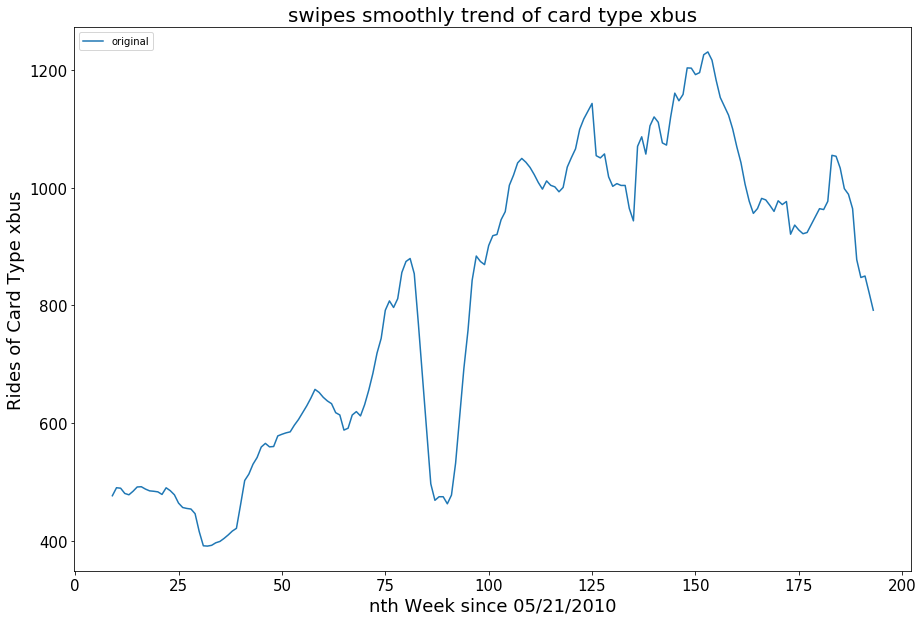

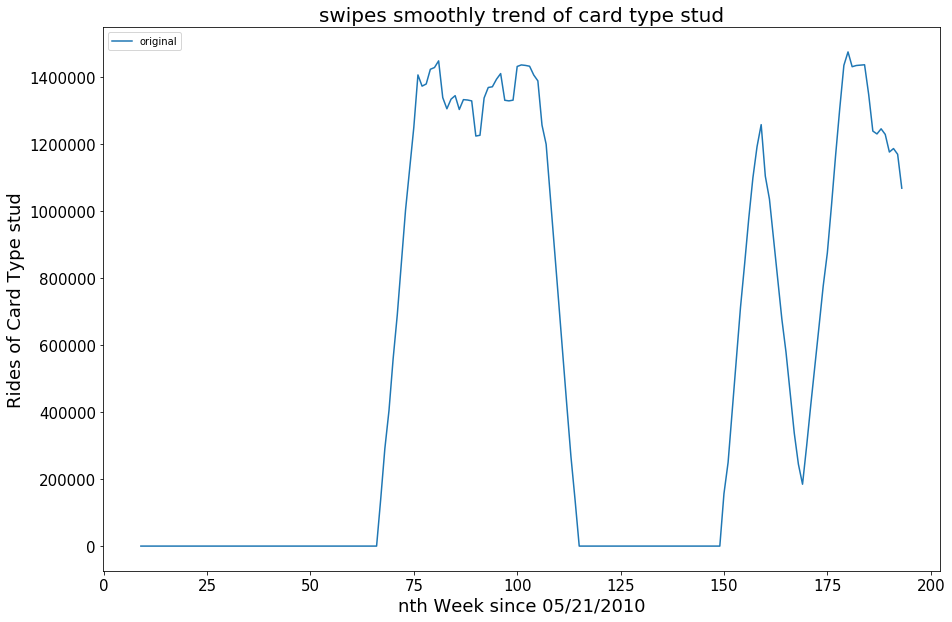

In [19]:
for i in ridetype:   
    fig = pl.figure(figsize=(15,10))
    #rolling mean, window 10
    #ax.set_title("Mean (rolling mean, window 10 dp) of Card Type %s" % i, fontsize=15)
    pl.xlabel("nth Week since 05/21/2010", fontsize=18)
    pl.ylabel(("Rides of Card Type %s" % i), fontsize=18)
    pl.xticks(fontsize = 15)
    pl.yticks(fontsize = 15)
    ax = pl.plot(df[i], label="original")
    pl.title("swipes smoothly trend of card type %s"%i,fontsize =20)
    pl.legend(loc = 2)
    pl.show()

Figure 4: plotting smoothly trends seperately. Obvious tendency we can find there.

In [20]:
ratio =[]
#for i in ridetype:
ratio.append(df.head(10).sum()/df.tail(10).sum())
    #print ("The ratio of first 10 weeks to last 10 weeks is , card type: %s"%i)
ratio

[10t          0.095168
 14d          0.075306
 1d           0.085422
 2t           0.102776
 30d          0.093478
 7d           0.068598
 ada          0.108593
 afas       492.434978
 exp       9410.910920
 ez       50354.512605
 ff           0.115499
 mc           0.081234
 mr           0.000004
 month        0.166127
 rfm          0.153947
 rr           0.037917
 sen          0.034026
 spec         0.001301
 tcmc         0.060115
 t            0.094460
 umlim        0.118547
 xbus         0.051623
 stud         0.000000
 dtype: float64]

### From the plots and statistics we find month shows a steadly decreasing trend and 14d/7d/sen/rr shows increasing trend, the ratios are posted above.


## Task 3:
### Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

In [22]:
mta_typesum = np.nansum(mta, axis=1)
print (mta_typesum.shape)

(600, 194)


In [23]:
mta_typesum_t = mta_typesum.T
mta_typesum_t.shape

(194, 600)

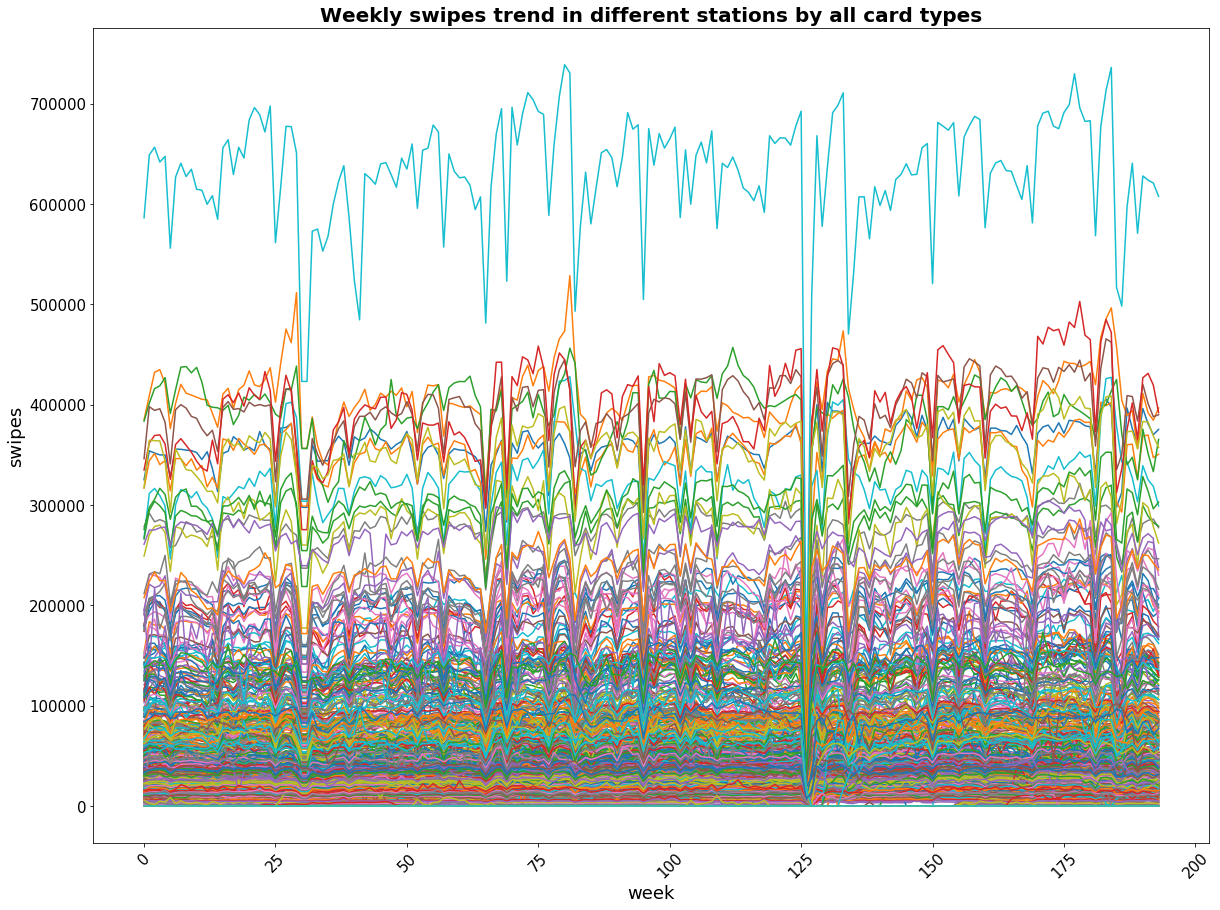

In [25]:
pl.figure(figsize=(20,15))
pl.plot(mta_typesum_t)
pl.xlabel("week", fontsize=18)
pl.ylabel("swipes", fontsize=18)
pl.xticks(rotation=45, fontsize=15)
pl.yticks(fontsize=15)
pl.title('Weekly swipes trend in different stations by all card types', fontsize = 20, weight='bold')
pl.show()

Figure 5 : All swipes record weekly in 600 stations. We can't collect periodcity from this plot obviously.

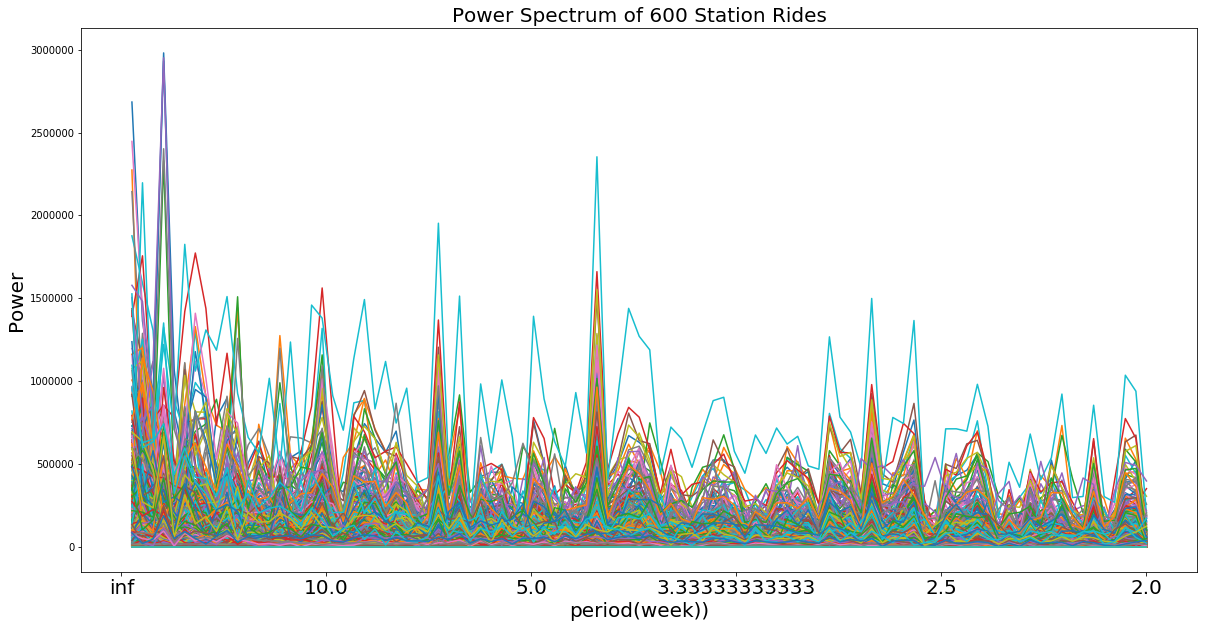

In [61]:
N = len(date)

fig = pl.figure(figsize=(20,10))
ax = fig.add_subplot(111)

for i in range(len(mta_typesum)):
    f = np.abs(np.fft.rfft(mta_typesum[i]))
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')

# changing the labels on the x ticks to see the period instead of frequency
ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
pl.xlabel("period(week))", fontsize=20)
pl.ylabel("Power", fontsize=20)
pl.title("Power Spectrum of 600 Station Rides", fontsize=20)
pl.show();



Figure 6 : Power spectrum of 600 stations swipes. X axis shows the period, what we want is 52. Y axis represents how the periodcity is, higher y value means more periodcity.

In [43]:
most = []
for i in range(len(mta_typesum)):
    f = np.abs(np.fft.rfft(mta_typesum[i]))
    if f[4] > 2400000: 
        most.append(i)

In [44]:
most

[0, 150, 194, 327]

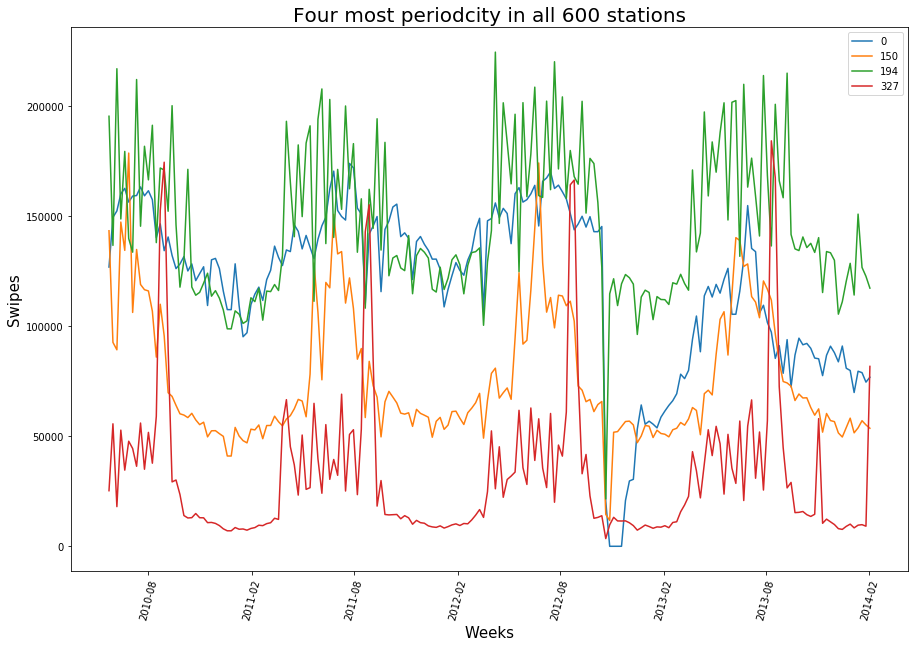

In [50]:
pl.figure(figsize=(15,10))
for i in most:
    pl.plot(date,mta_typesum[i],label=i)
pl.xticks(rotation=75)
pl.xlabel('Weeks',fontsize = 15)
pl.ylabel('Swipes',fontsize =15)
pl.title("Four most periodcity in all 600 stations",fontsize=20)
pl.legend()
pl.show()

Figure 7 : We plot the most 4 periodcity swipes records of stations 0/150/194/327. I think the peaks appearances are due to summer because people get outdoors more frequently in summer seansons and people get outdoors in winter can not stand the cold subway stations. What's more, the significant drops between 2012-08 and 2013-02 are due to Sandy.

## EXTRA CREDIT: Cluster. 
### Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
### Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

```
tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T
```

removing empty light curves

```
tots = tots[tots.std(1)>0]
```

with Kmeans you have to choose the number of clusters ahead km = 

```
KMeans(n_clusters=10)
```

and standardize the lightcurves before clustering. Notice: standardize, not whiten! If you have done clustering before you may have whitened the data: removed the variance by "column", here you want to remove the variance by "row". We will discuss this in the clustering lecture. 
```
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
```

then you can run:

```
km.fit(vals)
```

In [63]:
tots = mta.transpose(2,0,1).reshape(mta.shape[2], mta.shape[1]*mta.shape[0]).T

In [68]:
tots = tots[tots.std(1)>0]
tots.shape

(7660, 194)

In [70]:
tots

array([[ 3292.,  3429.,  3629., ...,  3746.,  3406.,  3217.],
       [  110.,    92.,   102., ...,   212.,   209.,   211.],
       [    7.,     6.,    13., ...,    26.,    20.,    22.],
       ..., 
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,  1959.,  1773.,  1667.],
       [  202.,   150.,   135., ...,   213.,   168.,   214.]])

In [73]:
km = KMeans?

In [74]:
km = KMeans(n_clusters=10)

In [75]:
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
vals.shape;
vals

array([[-0.65640584, -0.30638067,  0.20460498, ...,  0.50353158,
        -0.36514402, -0.84802546],
       [-0.79328051, -1.20611739, -0.97676357, ...,  1.54612853,
         1.47732238,  1.52319315],
       [-1.34422851, -1.46712217, -0.6068666 , ...,  0.99075089,
         0.25338898,  0.49917628],
       ..., 
       [-0.07198158, -0.07198158, -0.07198158, ..., -0.07198158,
        -0.07198158, -0.07198158],
       [-2.21145941, -2.21145941, -2.21145941, ...,  0.53025565,
         0.26993968,  0.12158756],
       [ 0.16821441, -0.85404281, -1.14892471, ...,  0.38446113,
        -0.50018454,  0.40411993]])

In [78]:
kmfit = km.fit(vals)

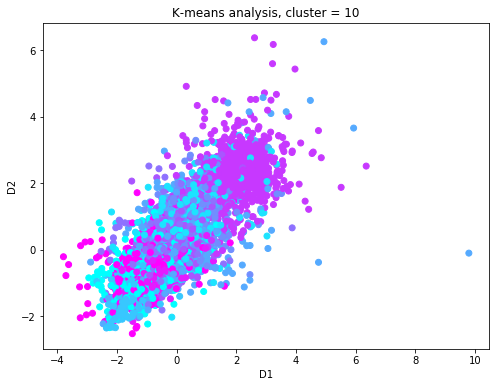

In [80]:
pl.figure(2, figsize=(8, 6))
pl.clf()
pl.scatter(vals[:, 0], vals[:, 1], c=kmfit.labels_, cmap=pl.cm.cool)
pl.xlabel('D1', fontsize = 10)
pl.ylabel('D2', fontsize = 10)
pl.title("K-means analysis, cluster = 10")
pl.show()

Figure 8: Kmeans analysis for clustring, number of clusters is 10.

In [88]:
for i in range(2,11):

    clusterer = KMeans(n_clusters=i, random_state=324)
    cluster_labels = clusterer.fit_predict(vals)
    silhouette_avg = silhouette_score(vals, cluster_labels)
    print("For n_clusters =", i,
          "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.287924447168
For n_clusters = 3 The average silhouette_score is : 0.264469831372
For n_clusters = 4 The average silhouette_score is : 0.248768176098
For n_clusters = 5 The average silhouette_score is : 0.205894647288
For n_clusters = 6 The average silhouette_score is : 0.215446995485
For n_clusters = 7 The average silhouette_score is : 0.214048804778
For n_clusters = 8 The average silhouette_score is : 0.213230111002
For n_clusters = 9 The average silhouette_score is : 0.214163740435
For n_clusters = 10 The average silhouette_score is : 0.205367313453


In [89]:
km = KMeans(n_clusters=2)
fit = km.fit(vals)

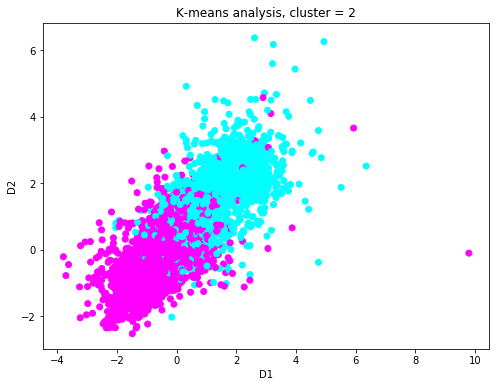

In [91]:
pl.figure(2, figsize=(8, 6))
pl.clf()
pl.scatter(vals[:, 0], vals[:, 1], c=fit.labels_, cmap=pl.cm.cool)
pl.xlabel('D1', fontsize = 10)
pl.ylabel('D2', fontsize = 10)
pl.title("K-means analysis, cluster = 2")
pl.show()

Figure 9 : Kmeans clustering for mta rides, cluster amount is 2 which is better than 10.

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. Look at the notebook on fourier transforms in https://github.com/fedhere/UInotebooks/tree/master/timeseries. If you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft()  

```
np.fft.rfft(mydata) 
```  

      will return the *real* part of the fourier transform (the fourier transform is a *complex* object, and therefore it has a real and an *imaginary* component - that is just math; all you need to know is that you need the real part). But what you want is its absolute value: np.abs(). 
      To plot the fourier transform you may want the x-axis to be in frequency. To get the x-axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

```
np.fft.rfftfreq(N, d) 
```     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the *sample spacing*, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1!)


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

*  after you operate on the array to collapse an axis, always check the dimensionality to assure you have indeed collapsed the right axis! see cell below

```
import numpy as np
data = np.random.rand(100,10)

print(data.shape)
Out[12]: (100, 10)

print(data.mean())
Out[13]:  0.4902457782

print(data.mean(axis=0).shape, data.mean(axis=1).shape)
Out[14]: (10,) (100,)

```